# ECG Anomaly Detection Using Autoencoders

**Dataset:** ecg.csv

Use Autoencoder to implement anomaly detection. Build the model by using:
1. Import required libraries
2. Upload / access the dataset
3. Encoder converts it into latent representation
4. Decoder networks convert it back to the original input
5. Compile the models with Optimizer, Loss, and Evaluation Metrics

### 1: Import Required Libraries

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

### 2: Upload / Access the Dataset

In [3]:
# Load ECG dataset for anomaly detection
path = 'Datasets/ecg.csv'
df = pd.read_csv(path, header=None)

# Drop any irrelevant columns if necessary (adjust if dataset structure varies)
df = df.drop(140, axis=1)  # Dropping 140th column as in the reference

# Preprocess data using StandardScaler
scaler = StandardScaler()
df = scaler.fit_transform(df)

# Split data into train and test sets
x_train, x_test = train_test_split(df, test_size=0.2)

### 3. Build the Encoder and Decoder Networks

The encoder compresses the data to a latent representation, and the decoder reconstructs it back to the original form.

In [4]:
encoder = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(x_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu')
])

decoder = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(8,)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(x_train.shape[1], activation='linear')  # Linear for reconstruction
])

autoencoder = tf.keras.models.Sequential([encoder, decoder])

### 4. Compile and Train the Model

We use the `mean_squared_error` loss function, which is commonly used in anomaly detection because it emphasizes reconstruction errors for abnormal samples.

Epoch 1/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8898 - val_loss: 0.4103
Epoch 2/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3961 - val_loss: 0.3038
Epoch 3/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3025 - val_loss: 0.2377
Epoch 4/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2319 - val_loss: 0.2101
Epoch 5/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2127 - val_loss: 0.1996
Epoch 6/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2040 - val_loss: 0.1910
Epoch 7/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1922 - val_loss: 0.1803
Epoch 8/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1816 - val_loss: 0.1705
Epoch 9/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1820 - val_loss: 0.1632
Epoch 10/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1809 - val_loss: 0.1571


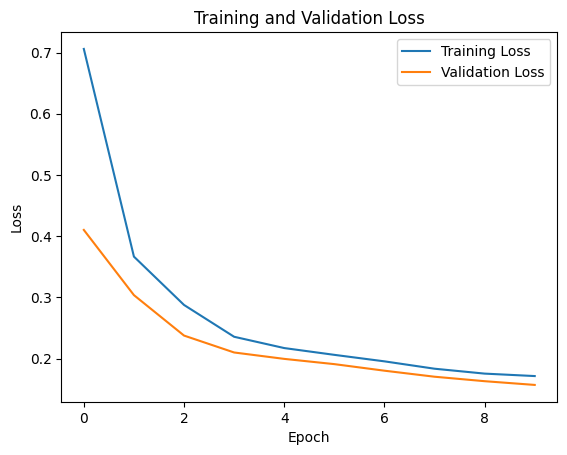

In [5]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

history = autoencoder.fit(
    x_train, 
    x_train, 
    validation_data=(x_test, x_test),
    epochs=10,
    batch_size=30,
    shuffle=True
)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

### Anomaly Detection

The model calculates the Mean Squared Error (MSE) between the input and reconstructed outputs, which helps in identifying anomalies. Any sample with an MSE higher than the defined threshold is flagged as an anomaly.

In [6]:
predictions = autoencoder.predict(x_test)
mse = np.mean(np.power(x_test - predictions, 2), axis=1)

# Define an anomaly detection threshold
threshold = np.percentile(mse, 95)  # Adjust percentile for sensitivity
anomalies = mse > threshold
num_anomalies = np.sum(anomalies)

print(f"Anomaly Detection Threshold: {threshold}")
print(f"Number of Anomalies Detected: {num_anomalies}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Anomaly Detection Threshold: 0.44223503404637426
Number of Anomalies Detected: 50


### Visualize the Results

### Plot Mean Squared Error (MSE) with Threshold

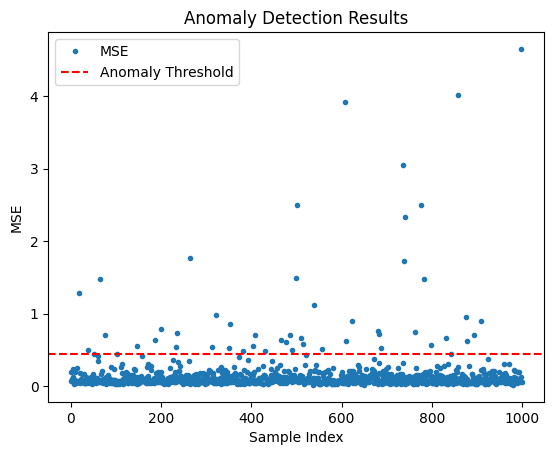

In [7]:
plt.plot(mse, marker='o', linestyle='', markersize=3, label='MSE')
plt.axhline(threshold, color='r', linestyle='--', label='Anomaly Threshold')
plt.xlabel('Sample Index')
plt.ylabel('MSE')
plt.title('Anomaly Detection Results')
plt.legend()
plt.show()

#### Plot an Example of Original vs. Reconstructed Signal

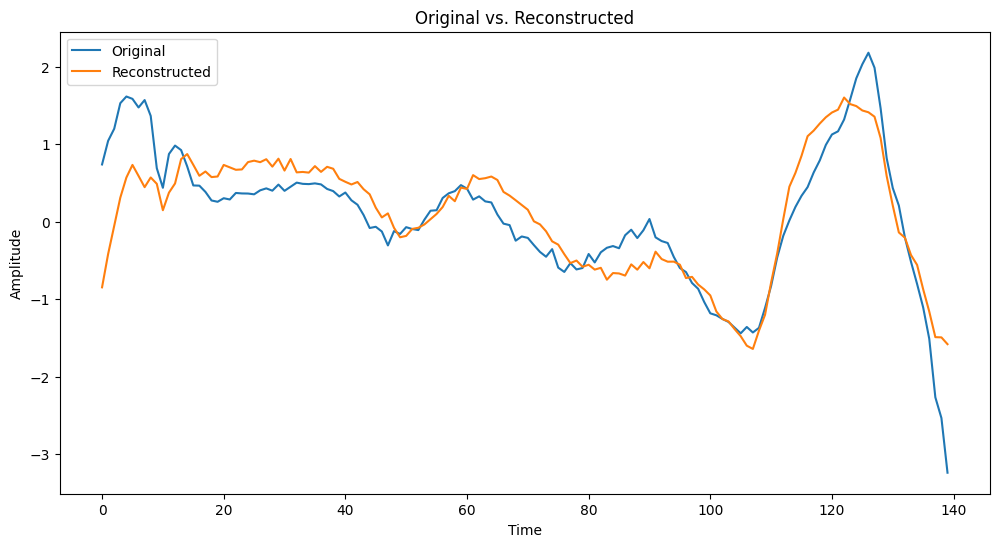

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(x_test[0], label='Original')
plt.plot(predictions[0], label='Reconstructed')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Original vs. Reconstructed')
plt.show()

#### Confusion Matrix for Anomaly Evaluation

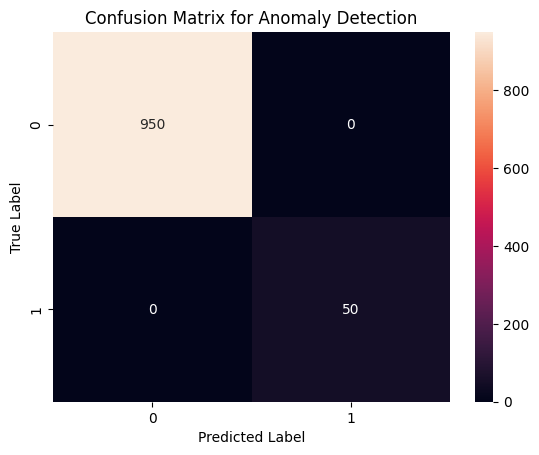

In [9]:
sns.heatmap(confusion_matrix(anomalies, anomalies), annot=True, fmt='d')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Anomaly Detection")
plt.show()